# Lab notebook

## Overview
This notebook records basic analysis of the project aiming at compare the performances of HyAsP and MOB-recon on tw data sets of *E faecalis* and *E facium* samples.

In [52]:
# Python packages.
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

import journal_utils

## E faecalis data, 2022-10-02

The *E faecalis* data set is available at [2022-10-02_E_faecalis](../data/2022-10-02_E_faecalis/README.md).

The summary files are the [list of samples](../data/2022-10-02_E_faecalis/E_faecalis_samples.txt) and the [labeling of contigs](../data/2022-10-02_E_faecalis/E_faecalis_labels.csv).

In [2]:
# Data set summary files
E_faecalis_samples_file = '../data/2022-10-02_E_faecalis/E_faecalis_samples.txt'
E_faecalis_labels_file = '../data/2022-10-02_E_faecalis/E_faecalis_labels.csv'

E_faecalis_samples_list = journal_utils.samples_file2list(E_faecalis_samples_file)
E_faecalis_labels_df = pd.read_csv(E_faecalis_labels_file)

In [3]:
# Statsitics on samples
E_faecalis_nb_samples_from_list = len(E_faecalis_samples_list)
E_faecalis_samples_from_labels = list(E_faecalis_labels_df['SRA'].unique())
E_faecalis_nb_samples_from_labels = len(E_faecalis_samples_from_labels)
E_faecalis_samples_diff_list = journal_utils.diff_lists(E_faecalis_samples_list, E_faecalis_samples_from_labels)
E_faecalis_samples_diff_labels = journal_utils.diff_lists(E_faecalis_samples_from_labels, E_faecalis_samples_list)

print(f'There are {E_faecalis_nb_samples_from_list} E.faecalis samples and {E_faecalis_nb_samples_from_labels} samples from the labels file')
print(f'Samples from list but not from labels: {",".join(E_faecalis_samples_diff_list)}')
print(f'Samples from labels but not from list: {",".join(E_faecalis_samples_diff_labels)}')

There are 56 E.faecalis samples and 60 samples from the labels file
Samples from list but not from labels: 
Samples from labels but not from list: SRR13726590,SRR13725727,SRR13726582,SRR14024961


**WARNING.**
There is an issue with the provided data as there are 4 samples that are provided with labels but are not in the list of samples for which data is available.

We discard the contigs from the corresponding samples in the database of contig labels.

In [26]:
# Discarding from the labeld dataframe rows from samples is not in the list of samples
E_faecalis_labels_df = E_faecalis_labels_df[~E_faecalis_labels_df['SRA'].isin(E_faecalis_samples_diff_labels)]
# Plasmid and chromosome contigs
E_faecalis_labels_df_plasmid = E_faecalis_labels_df.loc[E_faecalis_labels_df['classification']=='plasmid']
E_faecalis_labels_df_chromosome = E_faecalis_labels_df.loc[E_faecalis_labels_df['classification']=='chromosome']

In [36]:
# Statistics on contigs
E_faecalis_nb_contigs = len(E_faecalis_labels_df.index)
E_faecalis_nb_plasmid_contigs = len(E_faecalis_labels_df_plasmid.index)
E_faecalis_nb_chromosome_contigs = len(E_faecalis_labels_df_chromosome.index)

print(f'There are {E_faecalis_nb_contigs} hybrid contigs with a label.')
print(f'There are {E_faecalis_nb_plasmid_contigs} plasmid hybrid contigs.')
print(f'There are {E_faecalis_nb_chromosome_contigs} plasmid hybrid contigs.')

if E_faecalis_nb_contigs != E_faecalis_nb_plasmid_contigs+E_faecalis_nb_chromosome_contigs:
    print('WARNING: some hybrid contigs are unlabeled')

There are 751 hybrid contigs with a label.
There are 67 plasmid hybrid contigs.
There are 684 plasmid hybrid contigs.


**Comments.**
This was a preliminary and very rough analysis of the data.
We could do more preliminary analysis, such as the length distribution of hybrid contigs for each class (plasmid or chromosome), see below.

Text(0.5, 0.98, 'Contigs length distribution by label')

<Figure size 640x480 with 0 Axes>

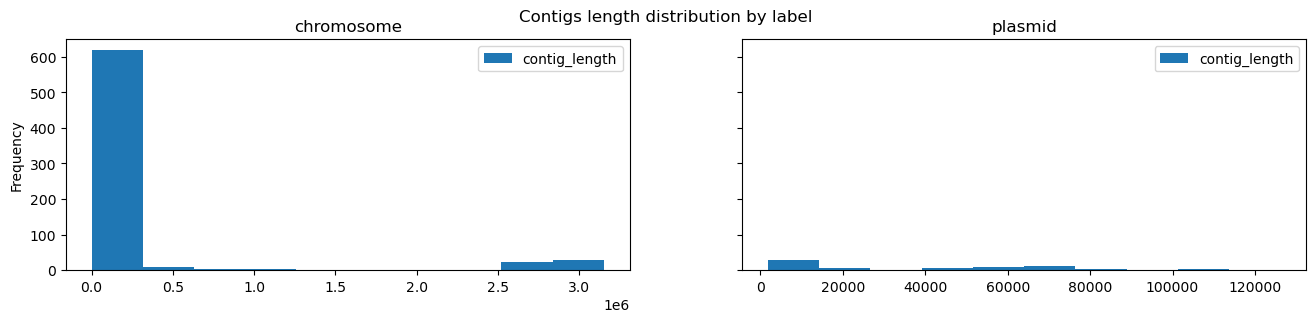

In [25]:
plt.figure()
ax = E_faecalis_labels_df.plot.hist(column=['contig_length'], by='classification', figsize=(16, 3), layout=(1,2), sharey=True)
plt.suptitle('Contigs length distribution by label')

As expected the plasmid contigs do not contain very large contigs.
We can however notice an apparently large number of hybrid contigs labeled as chromosomes and of short length, which might be a problem.

In [35]:
# Number of short chromosome contigs defined as chromosome contigs of length below the median length of plasmid contigs
E_faecalis_median_plasmid_ctg_len = E_faecalis_labels_df_plasmid['contig_length'].median()
E_faecalis_nb_short_chromosome_ctg = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_median_plasmid_ctg_len].index)
print(f'The number of chromosome contigs shorter than the median plasmid contig is {E_faecalis_nb_short_chromosome_ctg}')

The number of chromosome contigs shorter than the median plasmid contig is 450


Indeed we can see that many short contigs are labeled as chromosome, and this suggests a possible issue in the way the ground truth labels were obtained.
We look at the circularity of contigs to try to understand better the provided labels

In [46]:
# Number of circular and linear contigs in each class

# Thresholds defining what is a short hybrid chromoosme contig.
E_faecalis_short_circ_chromosome_ctgs_threshold = 2000000
E_faecalis_short_lin_chromosome_ctgs_threshold = 1000

E_faecalis_nb_circ_plasmid_ctgs = len(E_faecalis_labels_df_plasmid[E_faecalis_labels_df_plasmid['circularity']==1].index)
E_faecalis_nb_lin_plasmid_ctgs = len(E_faecalis_labels_df_plasmid[E_faecalis_labels_df_plasmid['circularity']==0].index)
E_faecalis_nb_circ_chromosome_ctgs = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['circularity']==1].index)
E_faecalis_nb_short_circ_chromosome_ctgs = len(
    E_faecalis_labels_df_chromosome[
        (E_faecalis_labels_df_chromosome['circularity']==1) & 
        (E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_short_circ_chromosome_ctgs_threshold)
    ].index
)
E_faecalis_nb_lin_chromosome_ctgs = len(E_faecalis_labels_df_chromosome[E_faecalis_labels_df_chromosome['circularity']==0].index)
E_faecalis_nb_short_lin_chromosome_ctgs = len(
    E_faecalis_labels_df_chromosome[
        (E_faecalis_labels_df_chromosome['circularity']==0) & 
        (E_faecalis_labels_df_chromosome['contig_length']<=E_faecalis_short_lin_chromosome_ctgs_threshold)
    ].index
)
print(f'Number of circular hybrid plasmid contigs: {E_faecalis_nb_circ_plasmid_ctgs}')
print(f'Number of linear hybrid plasmid contigs: {E_faecalis_nb_lin_plasmid_ctgs}')
print(f'Number of circular hybrid chromosome contigs: {E_faecalis_nb_circ_chromosome_ctgs}')
print(f'Number of short (<={E_faecalis_short_circ_chromosome_ctgs_threshold}) circular hybrid chromosome contigs: {E_faecalis_nb_short_circ_chromosome_ctgs}')
print(f'Number of linear hybrid chromosome contigs: {E_faecalis_nb_lin_chromosome_ctgs}')
print(f'Number of short (<={E_faecalis_short_lin_chromosome_ctgs_threshold}) linear hybrid chromosome contigs: {E_faecalis_nb_short_lin_chromosome_ctgs}')

Number of circular hybrid plasmid contigs: 67
Number of linear hybrid plasmid contigs: 0
Number of circular hybrid chromosome contigs: 24
Number of short (<=2000000) circular hybrid chromosome contigs: 0
Number of linear hybrid chromosome contigs: 660
Number of short (<=1000) linear hybrid chromosome contigs: 144


It looks like a contig needs to be circular to be labelled as plasmid but some circular contigs are also labelled as chromosome, likely fully assembled chromosomes.  
The number of short linear hybrid chromosome contigs suggest the provided ground truth is dubious.

## E faecium data, 2022-10-13

I would redo a similar analysis on this data once it is available.

## HyAsP database, 2022-10-14

In order to run HyAsP, we need to create a database of plasmid genes.  
This was done in [2022-10-14_HyAsP_database_NCBI](./2022-10-14_HyAsP_database_NCBI/README.txt)

We look at statistics o the number of genomes, species that were used and the distribution of length of the plasmid genes included in the database.

In [9]:
# Input plasmid data
HyAsP_NCBI_db_plasmids_df = pd.read_csv('./2022-10-14_HyAsP_database_NCBI/NCBI_plasmids.csv.gz')
# Genes in the final plasmid genes database
HyAsP_NCBI_db_genes_df = pd.read_csv('./2022-10-14_HyAsP_database_NCBI/NCBI_plasmid_genes_len.csv.gz')

In [10]:
# Number of different genomes
HyAsP_NCBI_db_plasmids_nb_genomes = len(HyAsP_NCBI_db_plasmids_df['Assembly'].unique())
HyAsP_NCBI_db_plasmids_nb_groups = len(HyAsP_NCBI_db_plasmids_df['Organism Groups'].unique())
HyAsP_NCBI_db_plasmids_nb_genes_in = sum(HyAsP_NCBI_db_plasmids_df['Genes'])

print(f'The HyAsP plasmid genes database was built from {HyAsP_NCBI_db_plasmids_nb_genomes} genomes from {HyAsP_NCBI_db_plasmids_nb_groups} groups.')
print(f'The input data for creating the database contains {HyAsP_NCBI_db_plasmids_nb_genes_in} genes.')

The HyAsP plasmid genes database was built from 5114 genomes from 56 groups.
The input data for creating the database contains 1560439 genes.


There is a large number of genomes, from many bacterial groups and covering a very large time period.  
We look now at the number of genes in the final database.

In [11]:
HyAsP_NCBI_db_genes_nb = len(HyAsP_NCBI_db_genes_df.index)

print(f'The final HyAsP plasmid genes database contains {HyAsP_NCBI_db_genes_nb} genes.')

The final HyAsP plasmid genes database contains 885018 genes.


We can see that the final database almost half of the genes from the initial set of assembled plasmids.

We can look at the dates where the genomes in the database were released.

Text(0.5, 1.0, 'Release dates of genomes used in HyAsP database')

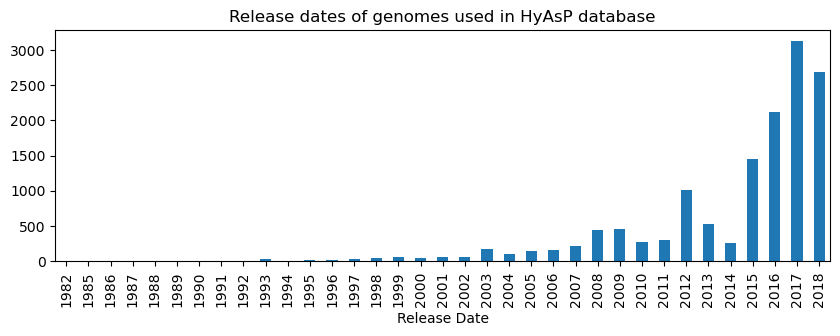

In [12]:
HyAsP_NCBI_db_plasmids_release = pd.Series(HyAsP_NCBI_db_plasmids_df['Release Date']).astype("datetime64")

plt.figure()
HyAsP_NCBI_db_plasmids_release.groupby([HyAsP_NCBI_db_plasmids_release.dt.year]).count().plot(kind='bar', figsize=(10,3))
plt.title('Release dates of genomes used in HyAsP database')

Text(0.5, 0.98, 'Genes length distribution in HyAsP NCBI database')

<Figure size 640x480 with 0 Axes>

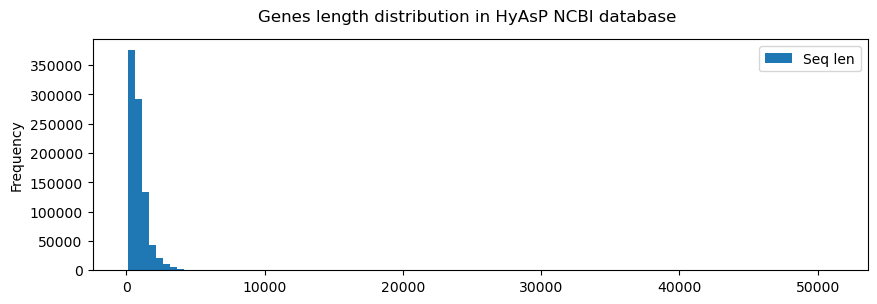

In [13]:
plt.figure()
ax = HyAsP_NCBI_db_genes_df.plot.hist(column=['Seq len'], figsize=(10,3), bins=100)
plt.suptitle('Genes length distribution in HyAsP NCBI database')

Text(0.5, 0.98, 'Short genes length distribution in HyAsP NCBI database')

<Figure size 640x480 with 0 Axes>

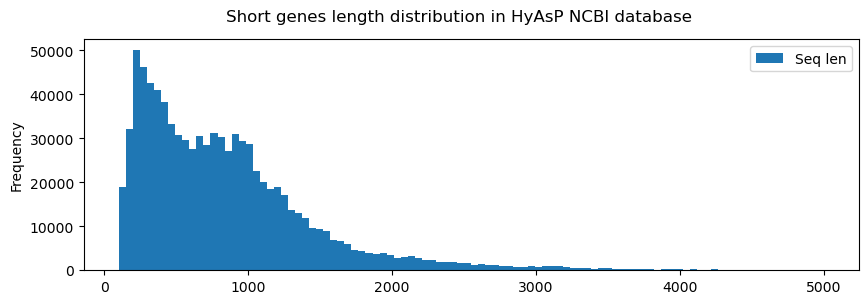

In [14]:
HyAsP_NCBI_db_genes_short_df = HyAsP_NCBI_db_genes_df[HyAsP_NCBI_db_genes_df['Seq len']<=5000]
plt.figure()
ax = HyAsP_NCBI_db_genes_short_df.plot.hist(column=['Seq len'], figsize=(10,3), bins=100)
plt.suptitle('Short genes length distribution in HyAsP NCBI database')

We can see that the databas contains short genes; while this is not surprising, the very large number of genes of length close to 200 bases is a concern.

## HyAsP experiment, 2022-10-15

We apply HyAsP, with the NCBI database to both the *E faecalis* and *E faecium* data sets.

In [15]:
# Results files
HyAsP_datasets = ['E_faecalis', 'E_faecium']
HyAsP_csv_files = {
    dataset: f'./2022-10-15_HyAsP/{dataset}_HyAsP_F1.csv'
    for dataset in HyAsP_datasets
}
# Results dataframes
HyAsP_F1_df = {
    dataset: pd.read_csv(HyAsP_csv_file)
    for dataset,HyAsP_csv_file in HyAsP_csv_files.items()
}

We first look at the number of samples in each data set where HyAsP did not precict any plasmid.

In [16]:
for dataset in HyAsP_datasets:
    dataset_df = HyAsP_F1_df[dataset]
    dataset_nb_NaN = len(dataset_df[dataset_df['F1'].isnull()].index)
    print(f'HyAsP did not predict plasmid for {dataset_nb_NaN} {dataset} samples.')

HyAsP did not predict plasmid for 9 E_faecalis samples.
HyAsP did not predict plasmid for 4 E_faecium samples.


Text(0.5, 0.98, 'HyAsP F1 distribution')

<Figure size 640x480 with 0 Axes>

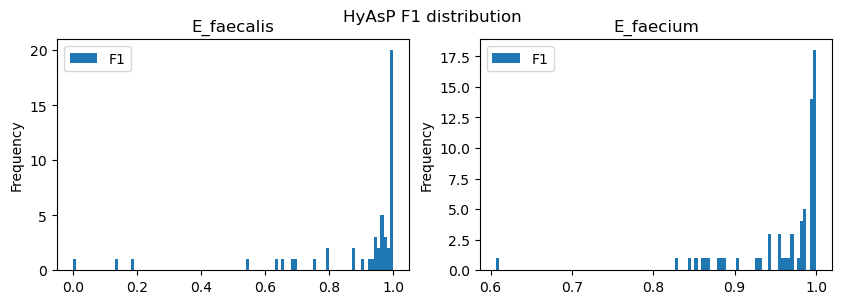

In [17]:
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(16,3))
for i, (dataset,dataset_df) in enumerate(HyAsP_F1_df.items()):
    dataset_df.plot.hist(ax=ax[i], column=['F1'], figsize=(10,3), bins=100, title=dataset)
plt.suptitle('HyAsP F1 distribution')

**TO DO.** Comment on the results. More analysis.